In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

2022-01-29 04:36:00.324412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:36:01.124588: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 04:36:01.125608: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 04:36:01.138109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-29 04:36:01.138130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:36:01.139467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/SIG_2021_11_16_no_iso_TEST.arrow')
bg_full = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg_full['is_signal'] = False
# bg_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/FULLBG_2021_11_16_no_iso_TEST.arrow')

In [3]:
bg_ZZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ZZ_RD.arrow')
bg_Zjets_old = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20211129_iso_e4m1_Zjets_RD.arrow')
bg_Zjets = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zjets_RD.arrow')
bg_Zgamma = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zgamma_RD.arrow')
bg_WZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_WZ_RD.arrow')
bg_tZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tZ_RD.arrow')
bg_tWZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tWZ_RD.arrow')
bg_ttZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ttZ_RD.arrow')
bg_other = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_others_RD.arrow')

bg_sources = [bg_ZZ, bg_Zjets, bg_Zgamma, bg_WZ, bg_tZ, bg_tWZ, bg_ttZ, bg_other]

In [4]:
for df in bg_sources:
    print(sum(df.wgt) / sum(bg_full.wgt))

0.9717740665613699
0.008909331116206785
0.0010556883632736617
0.004347097929154949
0.00016711686720929022
0.0025379501654372405
0.005859107932870372
0.006691005792313908


In [5]:
len(bg_Zjets_old)

130

In [6]:
len(bg_Zjets)

132

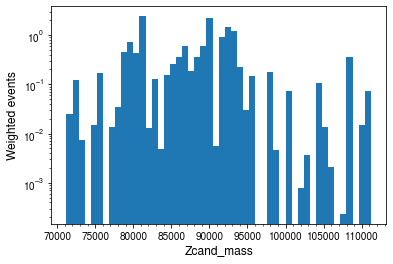

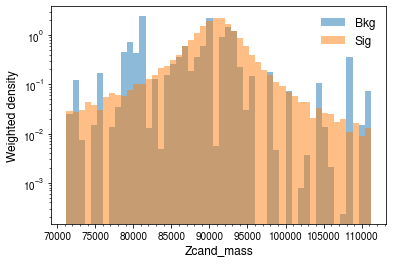

In [7]:
feat = 'Zcand_mass'


bg_source = bg_Zjets

plt.hist(bg_source[feat], weights=bg_source.wgt, bins=50)
plt.yscale('log')

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted events', fontsize=12)
plt.minorticks_on()

plt.show()

_, b, _ = plt.hist(bg_source[feat], weights=bg_source.wgt, density=False, bins=50, alpha=0.5, label='Bkg')
plt.hist(sig[feat], weights=sig.wgt, density=False, bins=b, alpha=0.5, label='Sig')

plt.legend(frameon=False, fontsize=12)

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted density', fontsize=12)
plt.minorticks_on()

plt.yscale('log')

In [8]:
# train_feats = ['Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 'pt_1', 'pt_2', 'Wlep2_pt_sqrt']
# train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
#                'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
#                'Zlep1_phi', 'Zlep2_phi', 'Wlep1_phi', 'Wlep2_phi', 
#                'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
#                'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
#                'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
#                'METSig', 'MET', 'Nlep', 'Njet',
#                'other_mass', 'leptonic_HT', 'total_HT', 'HT', 
#                'SR']

train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 'Zcand_mass', 'chisq']])

X = pd.concat([sig[train_feats_raw], bg_full[train_feats_raw]], ignore_index=True)

In [9]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg_full] + bg_sources:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

# Signal vs WZ

WZ events account for

In [10]:
current_bg = bg_WZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.43470979291549483

percent of the total background. The amount relative to signal is

In [11]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 2.1478386340407623 %
Weight: 36.52049729605499 %


Now we can scan over different training setups.

In [12]:
np.asarray(train_feats_raw)

array(['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi',
       'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi',
       'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi',
       'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi',
       'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT',
       'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
       'total_HT'], dtype='<U11')

In [13]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [ ]:
EPOCHS = 5000
patience = 500
batch_size = 512
num_nodes = 32
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(train_feat_sets):
    print('Running with training features:', train_feats)
    # Save training setup
    with open('models/background_id_models/classifier_WZ_train_feat_test_' + str(i) + '_setup.txt', 
              'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier_WZ = Sequential()
    classifier_WZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier_WZ.add(Dropout(dropout))
    classifier_WZ.add(Dense(num_nodes, activation='relu'))
    classifier_WZ.add(Dropout(dropout))
    classifier_WZ.add(Dense(num_nodes, activation='relu'))
    classifier_WZ.add(Dropout(dropout))
    classifier_WZ.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier_WZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier_WZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier_WZ.save('models/background_id_models/classifier_WZ_train_feat_test_' + str(i))
    with open('models/background_id_models/classifier_WZ_train_feat_test_' + str(i) + '_history.pkl', 
              'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
67/67 [==============================] - 1s 8ms/step - loss: 5.2510e-04 - accuracy: 0.0215 - val_loss: 5.4824e-04 - val_accuracy: 0.0210
Epoch 2/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1789e-04 - accuracy: 0.0196 - val_loss: 5.4578e-04 - val_accuracy: 0.0210
Epoch 3/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.3420e-04 - accuracy: 0.0210 - val_loss: 5.4375e-04 - val_accuracy: 0.0210
Epoch 4/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.4930e-04 - accuracy: 0.0218 - val_loss: 5.4

67/67 [==============================] - 0s 7ms/step - loss: 4.9172e-04 - accuracy: 0.0937 - val_loss: 5.1999e-04 - val_accuracy: 0.0632
Epoch 53/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.9253e-04 - accuracy: 0.1022 - val_loss: 5.1992e-04 - val_accuracy: 0.0685
Epoch 54/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0187e-04 - accuracy: 0.1043 - val_loss: 5.1985e-04 - val_accuracy: 0.0740
Epoch 55/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.2646e-04 - accuracy: 0.1056 - val_loss: 5.1980e-04 - val_accuracy: 0.0780
Epoch 56/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0886e-04 - accuracy: 0.1099 - val_loss: 5.1976e-04 - val_accuracy: 0.0836
Epoch 57/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.7436e-04 - accuracy: 0.1125 - val_loss: 5.1970e-04 - val_accuracy: 0.0906
Epoch 58/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.8358e-04 - accuracy: 0.1175 - v

67/67 [==============================] - 0s 7ms/step - loss: 5.2680e-04 - accuracy: 0.3135 - val_loss: 5.1836e-04 - val_accuracy: 0.4702
Epoch 107/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0680e-04 - accuracy: 0.3093 - val_loss: 5.1833e-04 - val_accuracy: 0.4753
Epoch 108/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.9573e-04 - accuracy: 0.3158 - val_loss: 5.1830e-04 - val_accuracy: 0.4772
Epoch 109/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.2248e-04 - accuracy: 0.3178 - val_loss: 5.1828e-04 - val_accuracy: 0.4797
Epoch 110/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.8154e-04 - accuracy: 0.3278 - val_loss: 5.1828e-04 - val_accuracy: 0.4888
Epoch 111/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0658e-04 - accuracy: 0.3288 - val_loss: 5.1827e-04 - val_accuracy: 0.4884
Epoch 112/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1548e-04 - accuracy: 0.32

Epoch 160/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1659e-04 - accuracy: 0.4354 - val_loss: 5.1751e-04 - val_accuracy: 0.5882
Epoch 161/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1315e-04 - accuracy: 0.4398 - val_loss: 5.1749e-04 - val_accuracy: 0.5867
Epoch 162/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.7210e-04 - accuracy: 0.4414 - val_loss: 5.1748e-04 - val_accuracy: 0.5873
Epoch 163/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0321e-04 - accuracy: 0.4434 - val_loss: 5.1745e-04 - val_accuracy: 0.5891
Epoch 164/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1254e-04 - accuracy: 0.4527 - val_loss: 5.1744e-04 - val_accuracy: 0.5915
Epoch 165/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.3578e-04 - accuracy: 0.4451 - val_loss: 5.1742e-04 - val_accuracy: 0.5905
Epoch 166/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.8525e-04 -

Epoch 214/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.5648e-04 - accuracy: 0.5129 - val_loss: 5.1674e-04 - val_accuracy: 0.6116
Epoch 215/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.3004e-04 - accuracy: 0.5074 - val_loss: 5.1671e-04 - val_accuracy: 0.6098
Epoch 216/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.8800e-04 - accuracy: 0.5125 - val_loss: 5.1670e-04 - val_accuracy: 0.6105
Epoch 217/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.8369e-04 - accuracy: 0.5080 - val_loss: 5.1667e-04 - val_accuracy: 0.6103
Epoch 218/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1691e-04 - accuracy: 0.5063 - val_loss: 5.1666e-04 - val_accuracy: 0.6110
Epoch 219/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.1278e-04 - accuracy: 0.5033 - val_loss: 5.1665e-04 - val_accuracy: 0.6130
Epoch 220/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.7326e-04 -

Epoch 268/5000
67/67 [==============================] - 0s 7ms/step - loss: 5.0701e-04 - accuracy: 0.5535 - val_loss: 5.1577e-04 - val_accuracy: 0.6345
Epoch 269/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.9876e-04 - accuracy: 0.5593 - val_loss: 5.1574e-04 - val_accuracy: 0.6346
Epoch 270/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.6709e-04 - accuracy: 0.5557 - val_loss: 5.1571e-04 - val_accuracy: 0.6341
Epoch 271/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.6731e-04 - accuracy: 0.5597 - val_loss: 5.1570e-04 - val_accuracy: 0.6361
Epoch 272/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.6977e-04 - accuracy: 0.5569 - val_loss: 5.1569e-04 - val_accuracy: 0.6372
Epoch 273/5000
67/67 [==============================] - 0s 7ms/step - loss: 4.9432e-04 - accuracy: 0.5655 - val_loss: 5.1565e-04 - val_accuracy: 0.6341
Epoch 274/5000
67/67 [==============================] - 0s 6ms/step - loss: 4.8242e-04 -